In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import chainer
from chainer.dataset import convert
import cv2
import net_conv
import hickle as hkl

/Users/Atsushi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
PATH = '../data/gol_large/'

In [3]:
X = hkl.load(PATH + 'X_train.hkl')
X = X / 255.
X = X.astype('float32')
sources = hkl.load(PATH + 'sources_train.hkl')

In [4]:
X2 = hkl.load(PATH + 'X_test.hkl')
X2 = X2 / 255.
X2 = X2.astype('float32')
sources2 = hkl.load(PATH + 'sources_test.hkl')

In [5]:
X3 = hkl.load(PATH + 'X_test.hkl')
X3 = X3 / 255.
X3 = X3.astype('float32')
sources3 = hkl.load(PATH + 'sources_test.hkl')

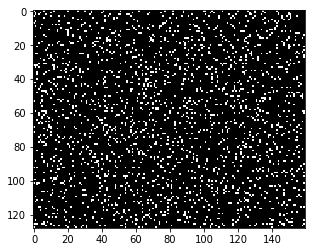

In [6]:
plt.imshow(X[0])

In [7]:
N = X[0].shape[0]
N2 = X[0].shape[1]
gpu = -1
dimz = 10
batchsize = 16
epoch = 100
initmodel = ''
resume = ''
out = 'result/gol_large'
is_test = False #'store_true'

In [8]:
print('GPU: {}'.format(gpu))
print('# dim z: {}'.format(dimz))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(epoch))
print('')

GPU: -1
# dim z: 10
# Minibatch-size: 16
# epoch: 100



In [9]:
# Initialize / Resume
if initmodel:
    chainer.serializers.load_npz(initmodel, model)
if resume:
    chainer.serializers.load_npz(resume, optimizer)

In [10]:
train = list()
for idx in range(len(X)-1):
    if sources[idx] == sources[idx+1]:
        train.append((np.transpose(X[idx], (2,0,1)), np.transpose(X[idx+1], (2,0,1))))

In [11]:
len(train)

900

In [12]:
test = list()
for idx in range(len(X2)-1):
    if sources2[idx] == sources2[idx+1]:
        test.append((np.transpose(X2[idx], (2,0,1)), np.transpose(X2[idx+1], (2,0,1))))

In [13]:
len(test)

90

In [14]:
test_for_plot = list()
for idx in range(len(X3)):
    test_for_plot.append(np.transpose(X3[idx], (2,0,1)))

In [15]:
test_for_plot[0].shape

(3, 128, 160)

In [16]:
random.shuffle(train)
random.shuffle(test)

In [17]:
if is_test:
    train, _ = chainer.datasets.split_dataset(train, 100)
    test, _ = chainer.datasets.split_dataset(test, 100)
train_count = len(train)
test_count = len(test)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [18]:
model = net_conv.ConvAE_mini(input_size=N, input_size2=N2, channel_size=3, n_filters=10, n_latent=dimz, filter_size=3, activation='relu')
# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [19]:
c = 1
while train_iter.epoch < epoch:
    sum_loss = 0
    batch = train_iter.next()
    x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
    x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
    x = chainer.Variable(x_array1)
    # Update model based on the loss function
    # defined by model.get_loss_func()
    optimizer.update(model.get_loss_func(), x, x_array2)
    sum_loss += float(model.loss.data) * len(x.data)
    if train_iter.is_new_epoch:
        print(c)
        c += 1
        print('train mean loss={}'.format(sum_loss / train_count))
        # evaluation
        sum_loss = 0
        for batch in test_iter:
            x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
            x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
            x = chainer.Variable(x_array1)
            loss_func = model.get_loss_func(k=10)
            loss_func(x, x_array2)
            sum_loss += float(model.loss.data) * len(x.data)
        test_iter.reset()
        print('test mean loss={}'.format(sum_loss / test_count))

/Users/Atsushi/anaconda3/lib/python3.6/site-packages/chainer/optimizers/adam.py:111: RuntimeWarning: invalid value encountered in sqrt
  param.data -= hp.eta * (self.lr * m / (numpy.sqrt(vhat) + hp.eps) +


1
train mean loss=542.2128472222222
test mean loss=29682.71176215278
2
train mean loss=272.60059027777777
test mean loss=15040.474826388889
3
train mean loss=147.79222222222222
test mean loss=8058.118880208333
4
train mean loss=108.90510416666666
test mean loss=5841.456336805555
5
train mean loss=86.41969618055556
test mean loss=4939.106857638889
6
train mean loss=86.12004340277778
test mean loss=4499.473773871528
7
train mean loss=74.25328993055555
test mean loss=4233.464534505209
8
train mean loss=70.85916666666667
test mean loss=4049.0745496961804
9
train mean loss=68.51922309027778
test mean loss=3916.04892578125
10
train mean loss=64.12484809027778
test mean loss=3819.6828993055556
11
train mean loss=74.67703125
test mean loss=3747.5523383246527
12
train mean loss=66.59932291666667
test mean loss=3689.7440809461805
13
train mean loss=62.88639756944445
test mean loss=3632.645166015625
14
train mean loss=56.55064236111111
test mean loss=3557.243353949653
15
train mean loss=64.884900

In [24]:
# Save the model and the optimizer
print('save the model')
chainer.serializers.save_npz(os.path.join(out, 'model.model'), model)
print('save the optimizer')
chainer.serializers.save_npz(os.path.join(out, 'state.state'), optimizer)

save the model
save the optimizer


In [20]:
# Visualize the results
def save_images(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi[0])
    fig.savefig(filename)

<Figure size 432x288 with 0 Axes>

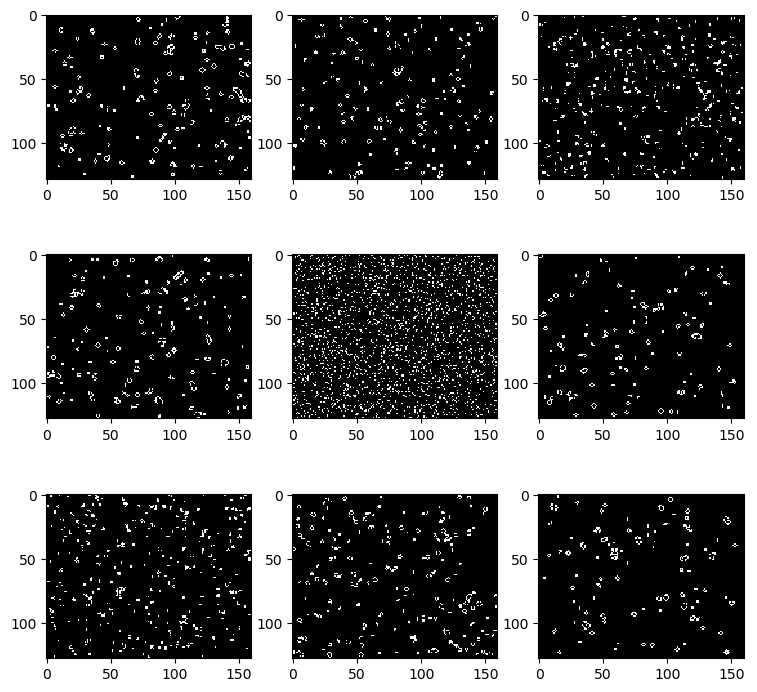

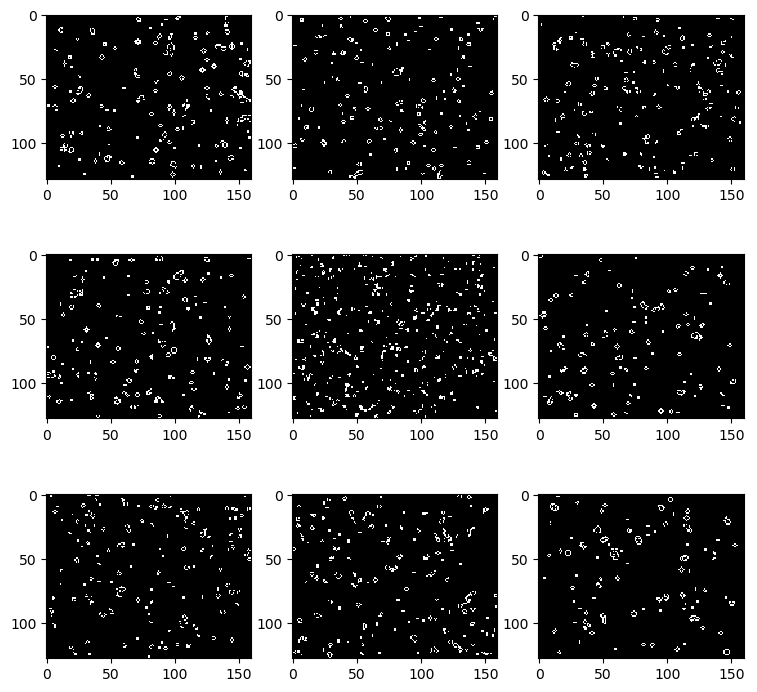

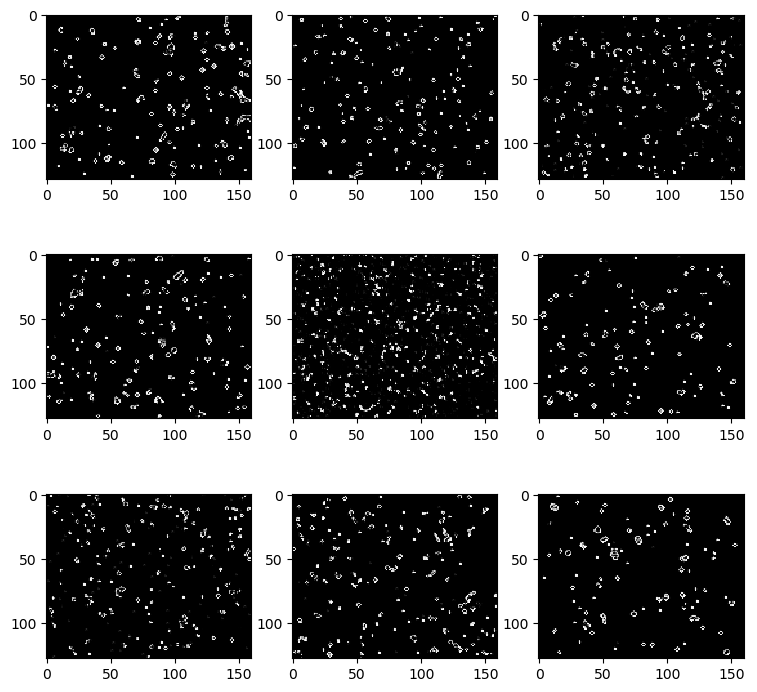

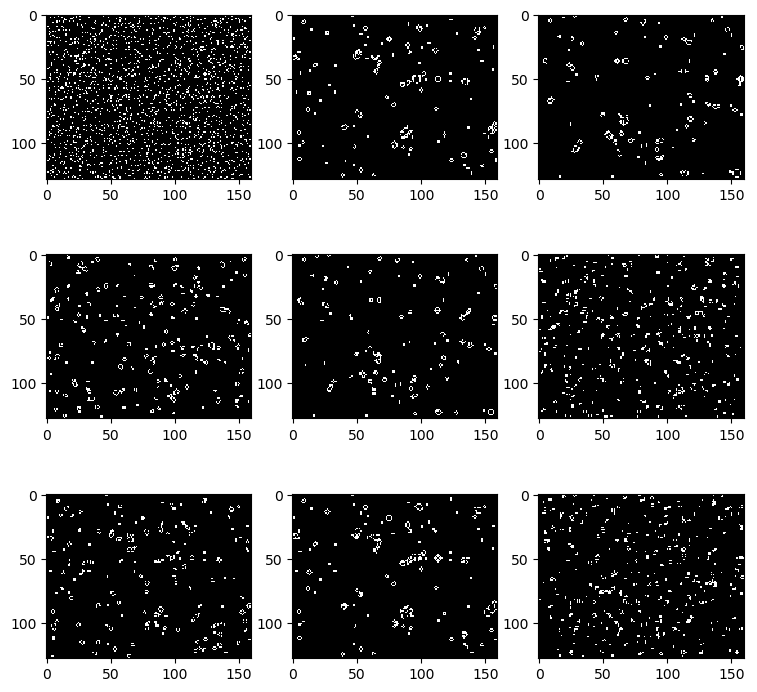

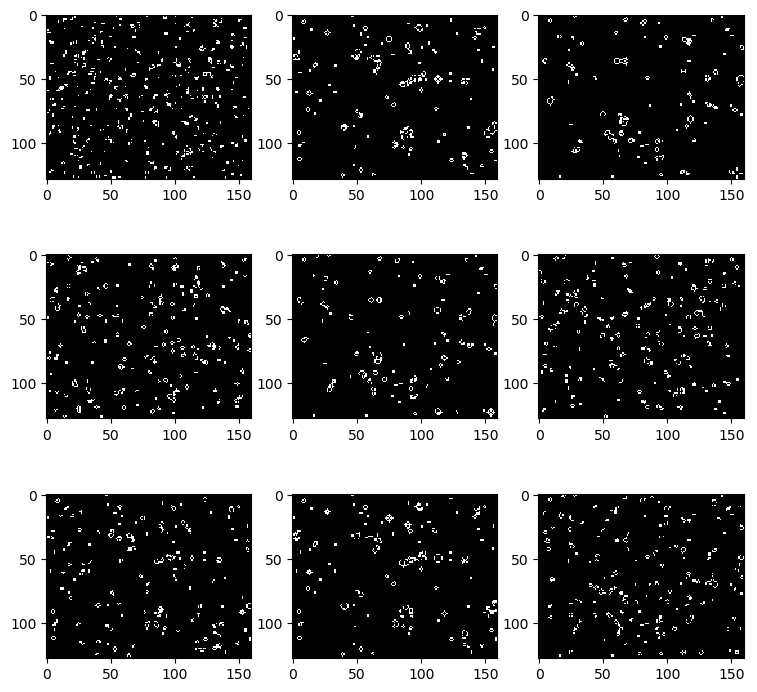

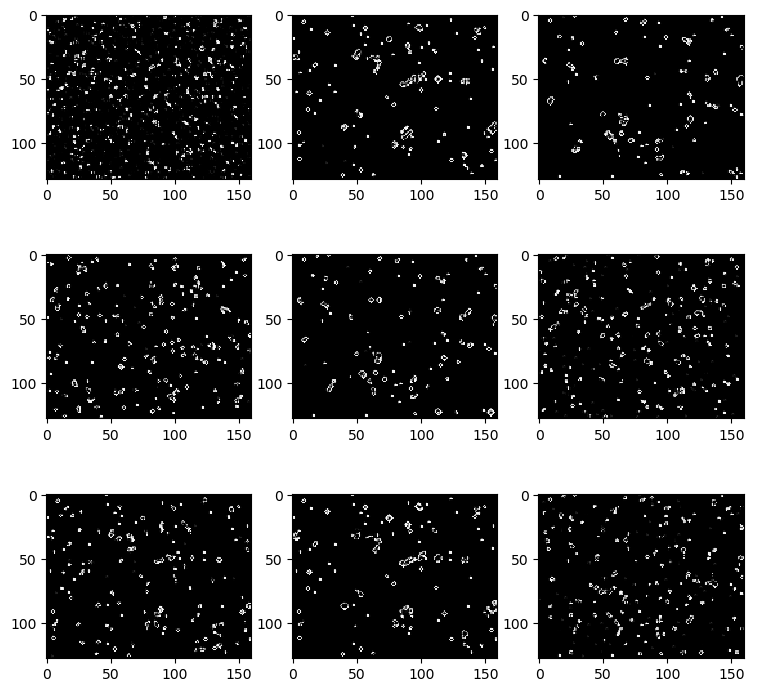

In [23]:
plt.gray()
model.to_cpu()
train_ind = np.random.randint(0,len(train),9)
# train_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(train)[train_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'train_x'))
save_images(x_array2, os.path.join(out, 'train_xnext'))
save_images(x1.data, os.path.join(out, 'train_xnextreconstructed'))

# test_ind = np.random.randint(0,len(test),9)
test_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(test)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'test_x'))
save_images(x_array2, os.path.join(out, 'test_xnext'))
save_images(x1.data, os.path.join(out, 'test_xnextreconstructed'))


## Can this model predict Glider? or not.

In [ ]:
PATH_glider = '../data/glider_small/'
X_g = hkl.load(PATH_glider + 'X_test.hkl')
X_g = X_g / 255.
X_g = X_g.astype('float32')
sources_g = hkl.load(PATH_glider + 'sources_test.hkl')

In [ ]:
plt.imshow(X_g[0])

In [ ]:
glider = list()
for idx in range(len(X_g)-1):
    if sources_g[idx] == sources_g[idx+1]:
        glider.append((np.transpose(X_g[idx], (2,0,1)), np.transpose(X_g[idx+1], (2,0,1))))

In [ ]:
# Visualize the results
def save_images2(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(5, 5, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi[0])
    fig.savefig(filename)

In [ ]:
glider_ind = range(25)#[0,1,2,3,4,5,6,7,8]
batch = np.asarray(glider)[glider_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images2(x_array1, os.path.join(out, 'glider_x'))
save_images2(x_array2, os.path.join(out, 'glider_xnext'))
save_images2(x1.data, os.path.join(out, 'glider_xnextreconstructed'))

plot for paper (same format with Prednet)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.gridspec as gridspec

In [ ]:
# test_ind = [0,1,2,3,4,5,6,7,8,9]
test_ind = list(np.linspace(0, 99, 100, dtype='int32'))
batch = np.asarray(test_for_plot)[test_ind]
# test_ind = list(np.linspace(0, 9, 10, dtype='int32'))
# batch = np.asarray(test_for_plot_glider)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x, batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

In [ ]:
x_array1.data.shape

In [ ]:
X_test = x_array1.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, N, N2, 3)
X_hat = x1.data.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, N, N2, 3)

In [ ]:
# plt.gray()
nt = 10
aspect_ratio = 0.8
# plt.figure(figsize = (nt, 2*aspect_ratio))
plt.figure(figsize = (100/7.2, 16/7.2))
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)
plot_save_dir = 'fig_for_paper/gol_large/'
if not os.path.exists(plot_save_dir): os.mkdir(plot_save_dir)
plot_idx = np.random.permutation(X_test.shape[0])

for i in plot_idx:
    for t in range(nt):     
        plt.subplot(gs[t])
        plt.imshow(X_test[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        if t % 10 == 0:
            plt.imshow(np.zeros(X_hat[0,0].shape), interpolation='none')
        else:
            plt.imshow(X_hat[i,t-1], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
    
    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()
plt.close()

In [ ]:
mse_model = 0
mse_prev = 0
c = 0
for i in range(len(X_test)):
    for j in range(len(X_test[0])-1):
        mse_model += np.mean((X_test[i,j+1,:,:] - X_hat[i,j,:,:])**2)
        mse_prev += np.mean((X_test[i,j+1,:,:] - X_test[i,j,:,:])**2)        
        c += 1

In [ ]:
mse_model/c

In [ ]:
mse_prev/c